In [1]:
import pandas as pd
import json
import os
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
sns.set(style='ticks', context='paper')
import numpy as np
from util import color_list,hatch_list,linestyle_list,markertype_list

In [2]:
def pn_distance(a, b, p):
    x = a.quantile(p)
    y = b.quantile(p)
    return (y - x) / x
    
def p99_distance(a, b):
    return pn_distance(a, b, 0.99)

P99_PERCENTILE_LIST = np.arange(1, 101, 1)

MTU=1000
BDP = 10 * MTU
bin_size_list=[MTU, BDP, 5 * BDP]
labels = {0: '0<size<=MTU', 1:'MTU<size<=BDP', 2:'BDP<size<=5BDP', 3:'5BDP<size'}

n_size_bucket_list_output=len(bin_size_list)+1
n_percentiles=len(P99_PERCENTILE_LIST)

file2matrix = {
    '../../workload/spatials/cluster_a_2_16.json': 'Matrix A',
    '../../workload/spatials/cluster_b_2_16.json': 'Matrix B',
    '../../workload/spatials/cluster_c_2_16.json': 'Matrix C',
}
file2dist = {
    '../../workload/distributions/facebook/webserver-all.txt': 'WebServer',
    '../../workload/distributions/facebook/hadoop-all.txt': 'Hadoop',
    '../../workload/distributions/facebook/cachefollower-all.txt': 'CacheFollower',
}
file2oversub = {
    'spec/cluster_1_to_1.json': '1-to-1',
    'spec/cluster_2_to_1.json': '2-to-1',
    'spec/cluster_4_to_1.json': '4-to-1',
}

In [3]:
mlsys_dir='mlsys_final_reprod_v1'
N_FLOW_THRESHOLD=10
NR_PATHS_SAMPLED=500
NR_INTEPOLATE=100
N_FLOWS=NR_PATHS_SAMPLED*NR_INTEPOLATE*4
def create_record(mix):
    mix_id = mix['id']
    mix_dir = f'../data/{mix_id}'
    
    # Load info
    with open(f'{mix_dir}/pmn-m/loads.json') as f:
        loads = json.load(f)
        loads.sort(reverse=True)
    loads = pd.DataFrame(loads, columns=['load'])
    max_load = loads['load'][0]
    idx = int(len(loads) * 0.1)
    top10pct_load = loads['load'][:idx].mean()

    assert (os.path.exists(f'../data/{mix["id"]}/{mlsys_dir}/elapsed.txt'))
    
    df_ns3 = pd.read_csv(f'{mix_dir}/ns3/records.csv')
    df_pmn_m = pd.read_csv(f'{mix_dir}/pmn-m/records.csv')
    sizes=df_pmn_m['size']
    # Accuracy metrics
    df_mlsys = []
    df_mlsys_per_bucket = [[] for _ in range(n_size_bucket_list_output)]
    n_freq_list=[]
    n_flow_list=[]
    path_idx=0
    while os.path.exists(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt'):
        with open(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt', 'r') as file:
            lines = file.readlines()
            data=lines[0].strip().split(",")
            n_freq=int(data[-1])
            n_freq_list.append(n_freq)
            
            flowid_list=[int(tmp) for tmp in lines[2].strip().split(",")]
            size_list=[sizes[flowid] for flowid in flowid_list]
            
            tmp=np.digitize(size_list, bin_size_list)
            # Count occurrences of each bin index
            bin_counts = np.zeros(n_size_bucket_list_output)
            for bin_idx in tmp:
                bin_counts[bin_idx]+=1
            n_flow_list.append(bin_counts)
        path_idx+=1
    
    n_flow_list=np.array(n_flow_list)
    n_flow_list_sum=n_flow_list.sum(axis=0)
    bucket_ratios_sampled=n_flow_list_sum/sum(n_flow_list_sum)
    
    with open(f'{mix_dir}/{mlsys_dir}/path.txt', 'r') as file:
        lines = file.readlines()
    lines = lines[1:]
    for line_idx,line in enumerate(lines):
        data=line.strip().split(",")
        data = [float(value) for value in data]
        n_freq=n_freq_list[line_idx//n_size_bucket_list_output]
        
        if n_flow_list[line_idx//n_size_bucket_list_output][line_idx%n_size_bucket_list_output]>=N_FLOW_THRESHOLD:
            for _ in range(n_freq):
                df_mlsys_per_bucket[line_idx%n_size_bucket_list_output].extend(data)
        
    for i in range(len(df_mlsys_per_bucket)):
        n_tmp=int(N_FLOWS*bucket_ratios_sampled[i])
        df_mlsys.extend(np.random.choice(df_mlsys_per_bucket[i],n_tmp,replace=True))
    
    df_mlsys=pd.DataFrame(np.array(df_mlsys).flatten())
    
    
    print(f"{mix_id}: len=",df_ns3.shape[0],df_pmn_m.shape[0],len(df_mlsys[0]))
    
    # was__ns3__pmn_m = wasserstein_distance(df_ns3['slowdown'], df_pmn_m['slowdown'])
    p99__ns3__pmn_m = p99_distance(df_ns3['slowdown'], df_pmn_m['slowdown'])
    # was__ns3__mlsys = wasserstein_distance(df_ns3['slowdown'], df_mlsys)
    p99__ns3__mlsys = p99_distance(df_ns3['slowdown'], df_mlsys[0])

    print(p99__ns3__pmn_m,p99__ns3__mlsys)
    record = {
        'id': mix['id'],
        'matrix': file2matrix[mix['spatial']],
        'size_dist': file2dist[mix['size_dist']],
        'lognorm_sigma': mix['lognorm_sigma'],
        'max_load_spec': mix['max_load'],
        'max_load': max_load,
        'top10pct_load': top10pct_load,
        'oversub': file2oversub[mix['cluster']],
        # 'was__ns3__pmn_m': was__ns3__pmn_m,
        'p99__ns3__pmn_m': p99__ns3__pmn_m,
        # 'was__ns3__mlsys': was__ns3__mlsys,
        'p99__ns3__mlsys': p99__ns3__mlsys,
    }
    return record
    
def get_records():
    mix_file = '../spec/all.mix.json'
    csv_file = 'main_sensitivity.csv'
    if os.path.exists(csv_file):
        mixes = pd.read_csv(csv_file)
    else:
        with open(mix_file) as f:
            mixes = json.load(f) 
        mixes = pd.DataFrame(list(map(create_record, mixes)))
        mixes.to_csv(csv_file, index=False)
    return mixes

records = get_records()
print(records.shape)

(192, 10)


## Max load

### CDFs

In [44]:
def ecdfplot(df, x):
    df['pct'] = df.groupby(by=['kind'], as_index=False)[x].rank(pct=True)
    plt.figure(figsize=(4, 1.5))
    ax = sns.lineplot(data=df, x=x, y='pct', hue='kind', style='kind', ci=None)
    ax.get_legend().set_title('Max load (top 10% avg)')
    ax.get_legend().set_frame_on(False)
    sns.despine()
    plt.ylabel('CDF')
    
def percentify(x):
    return f'{int(round(x, 2) * 100)}%'


In [7]:
print(records['max_load'].min())
print(records['max_load'].max())

0.2602780435058261
0.7748544133669228


In [8]:
worst_low_id=records['p99__ns3__mlsys'].idxmin()
worst_low_p99=records['p99__ns3__mlsys'].min()
worst_high_id=records['p99__ns3__mlsys'].idxmax()
worst_high_p99=records['p99__ns3__mlsys'].max()
print("{}:{}, {}:{}".format(worst_low_id, worst_low_p99, worst_high_id, worst_high_p99))
print(records[records['id']==worst_low_id])
print(records[records['id']==worst_high_id])

53:-0.1641504675773217, 30:0.2278941295275291
    id    matrix      size_dist  lognorm_sigma  max_load_spec  max_load  \
53  53  Matrix C  CacheFollower            2.0       0.739021  0.744086   

    top10pct_load oversub  p99__ns3__pmn_m  p99__ns3__mlsys  
53       0.307399  1-to-1         0.109277         -0.16415  
    id    matrix  size_dist  lognorm_sigma  max_load_spec  max_load  \
30  30  Matrix C  WebServer            2.0       0.262553  0.273809   

    top10pct_load oversub  p99__ns3__pmn_m  p99__ns3__mlsys  
30       0.131104  4-to-1         0.038431         0.227894  


median: 0.043415099804262,0.05978415660828605
 90%: 0.10148530785792054,0.12289079852246963
 max: 0.2278941295275291,0.4871533897306813


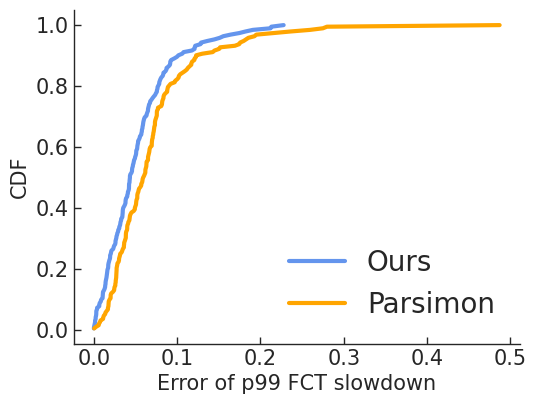

In [21]:
_fontsize=15
records_abs=records.copy()
records_abs['p99__ns3__mlsys']=abs(records_abs['p99__ns3__mlsys'])
records_abs['p99__ns3__pmn_m']=abs(records_abs['p99__ns3__pmn_m'])
column_list=['p99__ns3__mlsys','p99__ns3__pmn_m']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.2, 4.0), sharex=True)
ax.tick_params(axis="y", direction="in")
ax.tick_params(axis="x", direction="in")

for i,each in enumerate(column_list):
    data=records_abs
    data['pct'] = data[each].rank(pct=True)
    ax=sns.lineplot(data = data, x = each, y = 'pct', color = color_list[i], errorbar=None, ax=ax,linewidth=3,)
    
    # handles = ax.get_legend().get_lines()
    # ax.get_legend().remove()
labels=['Ours','Parsimon']
# XXX: This is a dirty hack. Look carefully at the labels!
plt.legend(labels=labels, loc='lower right', frameon=False, ncol=1,prop={"size": _fontsize+5})
sns.despine()
fig.tight_layout()
plt.xlabel('Error of p99 FCT slowdown', fontsize=_fontsize)
plt.ylabel('CDF', fontsize=_fontsize)
plt.yticks(fontsize=_fontsize)
plt.xticks(fontsize=_fontsize)
# plt.xlim(1.0)
plt.savefig('figs/sensitivity_cdf.pdf', bbox_inches='tight',pad_inches=0)
print(f"median: {np.median(records_abs['p99__ns3__mlsys'])},{np.median(records_abs['p99__ns3__pmn_m'])}\n 90%: {np.percentile(records_abs['p99__ns3__mlsys'], 90)},{np.percentile(records_abs['p99__ns3__pmn_m'], 90)}\n max: {np.max(records_abs['p99__ns3__mlsys'])},{np.max(records_abs['p99__ns3__pmn_m'])}")

/tmp/ipykernel_2696122/977165796.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='max_load', y=each, data=records_abs, color=color_list[i], ax=axs, label=labels[i], ci='sd', estimator='mean', lw=4)
/tmp/ipykernel_2696122/977165796.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='max_load', y=each, data=records_abs, color=color_list[i], ax=axs, label=labels[i], ci='sd', estimator='mean', lw=4)


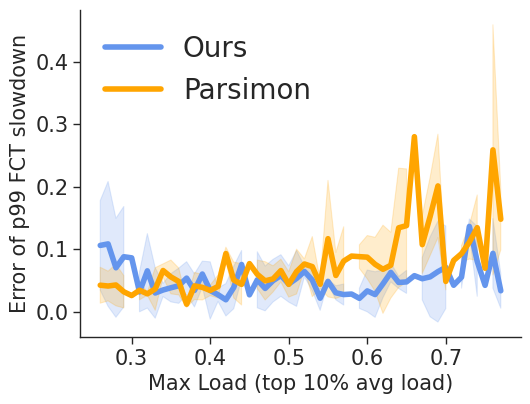

In [40]:
_fontsize=15
records_abs=records.copy()
records_abs['p99__ns3__mlsys']=abs(records_abs['p99__ns3__mlsys'])
records_abs['p99__ns3__pmn_m']=abs(records_abs['p99__ns3__pmn_m'])

records_abs['max_load']=records_abs['max_load']//0.01*0.01

records_abs=records_abs.sort_values(by='max_load')
column_list=['p99__ns3__mlsys','p99__ns3__pmn_m']
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5.2, 4.0), sharex=True)
labels=['Ours','Parsimon']
for i,each in enumerate(column_list):
    # ax=sns.scatterplot(data = records_abs, x = 'max_load', y = each, color = color_list[i], ax=axs, marker=markertype_list[i], s=30)
    # ax = sns.lineplot(data=records_abs, x='max_load', y=each, color=color_list[i], ax=axs, marker=markertype_list[i], label=each, ci='sd')
    # ax=sns.lineplot(data=records_abs, x='max_load', y=each, color=color_list[i], ax=axs, marker=markertype_list[i], label=each, ci=None, estimator='mean', lw=2)
    # sns.scatterplot(x='max_load', y=each, data=records_abs, color=color_list[i], ax=axs, label=f'{each} Raw', s=30)
    sns.lineplot(x='max_load', y=each, data=records_abs, color=color_list[i], ax=axs, label=labels[i], ci='sd', estimator='mean', lw=4)
    
    # print(f"{each}: ",records_abs[each].min(),records_abs[each].max())
    # handles = ax.get_legend().get_lines()
    # ax.get_legend().remove()
title=''

# XXX: This is a dirty hack. Look carefully at the labels!
# fig.legend(loc='upper right', frameon=False, ncol=1)
plt.legend(loc='upper left', frameon=False, ncol=1,prop={"size": _fontsize+5})
sns.despine()
fig.tight_layout()
plt.xlabel('Max Load (top 10% avg load)',fontsize=_fontsize)
plt.ylabel('Error of p99 FCT slowdown',fontsize=_fontsize)
plt.yticks(fontsize=_fontsize)
plt.xticks(fontsize=_fontsize)
plt.savefig('figs/sensitivity_error_over_load.pdf', bbox_inches='tight')

In [47]:
records = records.sort_values(by='max_load')
n = round(len(records) / 2)
records_l = records.iloc[0:n].copy()
records_h = records.iloc[n:].copy()

# records_l = records[records['max_load'] <= 0.5].copy()
# records_m = records[records['max_load'] <= 0.65].copy()
# records_h = records[records['max_load'] <= 1.0].copy()
max_load = records['max_load'].max()

max_load_l_min = records_l['max_load'].min()
max_load_h_min = records_h['max_load'].min()

max_load_l_max = records_l['max_load'].max()
max_load_h_max = records_h['max_load'].max()

top10pct_load_l_min = records_l['top10pct_load'].min()
top10pct_load_h_min = records_h['top10pct_load'].min()

top10pct_load_l_max = records_l['top10pct_load'].max()
top10pct_load_h_max = records_h['top10pct_load'].max()

records_l.loc[:, 'kind'] = 'low'
records_h.loc[:, 'kind'] = 'high'
records.loc[:, 'kind'] = 'all'
records_lmh = pd.concat([records_l, records_h,records], ignore_index=True)
# x_lim_range=(-1.0, 1.0)

In [48]:
# records_lmh['p99__ns3__ns3_path'] = records_lmh['p99__ns3__ns3_path'].abs()
records_lmh['p99__ns3__mlsys'] = records_lmh['p99__ns3__mlsys'].abs()
records_lmh['p99__ns3__pmn_m'] = records_lmh['p99__ns3__pmn_m'].abs()
# x_lim_range=(0, 1.0)

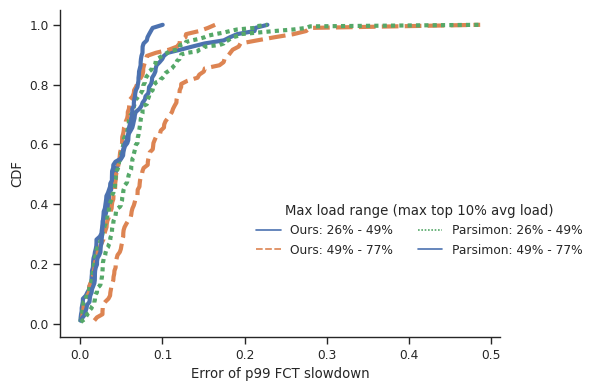

In [49]:
target_method_list=['p99__ns3__mlsys','p99__ns3__pmn_m']
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5.2, 4.0), sharex=True)
for i,target_method in enumerate(target_method_list):
    records_lmh['pct'] = records_lmh.groupby(by=['kind'], as_index=False)[target_method].rank(pct=True)
    ax = sns.lineplot(data=records_lmh, x=target_method, y='pct', hue='kind', style='kind', errorbar=None,color=color_list[i], linewidth=3)

handles = ax.get_legend().get_lines()
ax.get_legend().remove()
title='Max load range (max top 10% avg load)'
labels=[
    f'Ours: {percentify(max_load_l_min)} - {percentify(max_load_l_max)}',
    f'Ours: {percentify(max_load_h_min)} - {percentify(max_load_h_max)}',
    f'Parsimon: {percentify(max_load_l_min)} - {percentify(max_load_l_max)}',
    f'Parsimon: {percentify(max_load_h_min)} - {percentify(max_load_h_max)}',
]
# XXX: This is a dirty hack. Look carefully at the labels!
fig.legend(handles=handles, labels=labels, title=title, loc='lower right', frameon=False, ncol=2, bbox_to_anchor=(1.15, 0.32))
sns.despine()
fig.tight_layout()
plt.xlabel('Error of p99 FCT slowdown')
plt.ylabel('CDF')
plt.savefig('figs/error-dist-0.pdf', bbox_inches='tight')

###  Misc

In [15]:
records[target_method].max()
records['max_load'].quantile(0.6)
records_h[target_method].mean()
records[(records['oversub'] == '2-to-1') & (records['size_dist'] == 'WebServer') & (records['matrix'] == 'Matrix B')].sort_values(by=target_method, ascending=False).iloc[:10]

,id,matrix,size_dist,lognorm_sigma,max_load_spec,max_load,top10pct_load,oversub,was__ns3__pmn_m,p99__ns3__pmn_m,was__ns3__ns3_path,p99__ns3__ns3_path,was__ns3__flowsim,p99__ns3__flowsim,kind
63,63,Matrix B,WebServer,2.0,0.731133,0.808883,0.610737,2-to-1,0.489892,0.192121,1.040115,-0.500934,1.040115,-0.500934,all
74,74,Matrix B,WebServer,1.0,0.590949,0.654366,0.494073,2-to-1,0.219546,0.105964,0.647344,-0.530546,0.647344,-0.530546,all
183,183,Matrix B,WebServer,2.0,0.466966,0.516671,0.390106,2-to-1,0.135337,0.060288,0.423293,-0.531616,0.423293,-0.531616,all
175,175,Matrix B,WebServer,1.0,0.491736,0.544714,0.411281,2-to-1,0.135671,0.057512,0.442162,-0.533510,0.442162,-0.533510,all
146,146,Matrix B,WebServer,2.0,0.487395,0.539387,0.407257,2-to-1,0.149169,0.062126,0.459714,-0.537046,0.459714,-0.537046,all
68,68,Matrix B,WebServer,2.0,0.255738,0.282964,0.213648,2-to-1,0.048989,0.054818,0.149684,-0.546935,0.149684,-0.546935,all
29,29,Matrix B,WebServer,1.0,0.518351,0.574143,0.433500,2-to-1,0.155137,0.064026,0.491366,-0.547129,0.491366,-0.547129,all
17,17,Matrix B,WebServer,2.0,0.259027,0.286563,0.216365,2-to-1,0.049879,0.055913,0.152724,-0.550095,0.152724,-0.550095,all
168,168,Matrix B,WebServer,2.0,0.351868,0.389325,0.293955,2-to-1,0.078281,0.066477,0.257998,-0.572079,0.257998,-0.572079,all
24,24,Matrix B,WebServer,2.0,0.349409,0.386599,0.291896,2-to-1,0.077280,0.066895,0.255549,-0.573005,0.255549,-0.573005,all


### Less than 10% error?

In [16]:
pct_lt_10_l = len(records_l[records_l[target_method] <= 0.1]) / len(records_l)
pct_lt_10_m = len(records_m[records_m[target_method] <= 0.1]) / len(records_m)
pct_lt_10_h = len(records_h[records_h[target_method] <= 0.1]) / len(records_h)
pct_lt_10 = len(records[records[target_method] <= 0.1]) / len(records)
print(f'low: {percentify(pct_lt_10_l)}')
print(f'med: {percentify(pct_lt_10_m)}')
print(f'high: {percentify(pct_lt_10_h)}')
print(f'all: {percentify(pct_lt_10)}')

records_lm = pd.concat([records_l, records_m])
pct_lt_10_lm = len(records_lm[records_lm[target_method] <= 0.1]) / len(records_lm)
print(f'low-to-med: {int(round(pct_lt_10_lm, 2) * 100)}%')


low: 100%
med: 100%
high: 100%
all: 100%
low-to-med: 100%


### Fails to bound?

In [17]:
lt_0 = records[records[target_method] < 0.0]
pct_lt_0 = len(lt_0) / len(records)
print(f'{int(round(pct_lt_0, 2) * 100)}%')
print(lt_0[target_method].min())

100%
-0.865316163897542


## Everything else (fix moderate load)

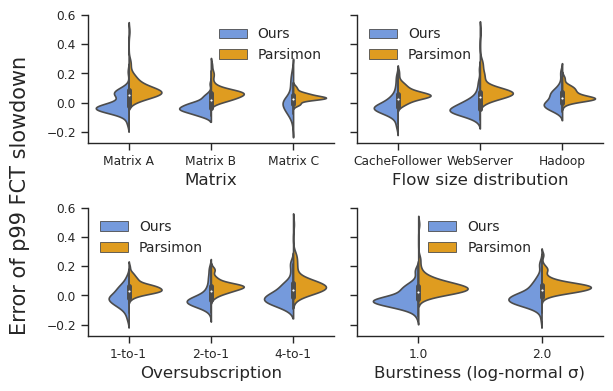

In [96]:
def violins(df):
    xs_labels_orders_rot = [
        ('matrix', 'Matrix', ['Matrix A', 'Matrix B', 'Matrix C'], 0),
        ('oversub', 'Oversubscription', ['1-to-1', '2-to-1', '4-to-1'], 0),
        ('size_dist', 'Flow size distribution', ['CacheFollower', 'WebServer', 'Hadoop'], 0),
        ('lognorm_sigma', 'Burstiness (log-normal σ)', [1.0, 2.0], 0),
    ]
    legend_loc_list=['upper right','upper left','upper left','upper center']
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6.2, 4.), sharey=True)

    for i, (x, label, order, rot) in enumerate(xs_labels_orders_rot):
        j, k = i % 2, int(i / 2)

        # Create a list of colors for each violin
        # colors = [f'C{i}' for i in range(len(df['kind'].unique()))]

        ax = sns.violinplot(
            data=df[df[x].isin(order)],
            x=x,
            y='error',
            hue='kind',
            order=order,
            ax=axs[j, k],
            split=True,
            palette=color_list,
        )
        ax.set_xlabel(label,fontsize=12)
        for tick in ax.get_xticklabels():
            tick.set_rotation(rot)
        ax.set_ylabel('')
    # Remove "kind" from the legend
    for idx,ax in enumerate(axs.flat):
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles[0:], labels=labels[0:],frameon=False,loc=legend_loc_list[idx],prop={"size": 10})
    sns.despine()
    fig.supylabel('Error of p99 FCT slowdown',fontsize=15)
    fig.tight_layout()

# Assuming records and 'kind' column are defined somewhere in your script
df_violin_pmn = records.copy()
df_violin_mlsys = records.copy()
df_violin_pmn['kind'] = 'Parsimon'
df_violin_pmn['error'] = (df_violin_pmn["p99__ns3__pmn_m"])
df_violin_mlsys['kind'] = 'Ours' 
df_violin_mlsys['error'] = (df_violin_mlsys["p99__ns3__mlsys"])
df_violin = pd.concat([df_violin_mlsys,df_violin_pmn], ignore_index=True)

violins(df_violin)
plt.savefig('figs/sensitivity_violin.pdf', bbox_inches='tight')
